# Resume Classification LSTM Project

## 1. Environment Setup

In [ ]:
!pip install -q kagglehub pandarallel spacy
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 96.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 2. Import Libraries

In [ ]:
import pandas as pd
import numpy as np

import spacy
from pandarallel import pandarallel

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


import re
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

pandarallel.initialize(progress_bar=True)

print("All libraries imported successfully!")

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
All libraries imported successfully!


## 3. Data Collection

In [ ]:
import kagglehub

print("Downloading Kaggle datasets...")
resume_dataset_path = kagglehub.dataset_download('gauravduttakiit/resume-dataset')
cvscsv_path = kagglehub.dataset_download('leenardeshmukh/cvscsv')
curriculum_vitae_path = kagglehub.dataset_download('leenardeshmukh/curriculum-vitae')
resume_analysis_path = kagglehub.dataset_download("kalimsattar/resume-analysis-datasets")

print('Kaggle datasets downloaded successfully!')

Using Colab cache for faster access to the 'resume-dataset' dataset.
Using Colab cache for faster access to the 'cvscsv' dataset.
Using Colab cache for faster access to the 'curriculum-vitae' dataset.
Using Colab cache for faster access to the 'resume-analysis-datasets' dataset.
Kaggle datasets downloaded successfully!


### 3.1 Load Individual DataFrames

In [ ]:
df1 = pd.read_csv(f'{resume_dataset_path}/UpdatedResumeDataSet.csv')
df2 = pd.read_csv(f'{cvscsv_path}/cvs.csv')
df3 = pd.read_csv(f'{curriculum_vitae_path}/Curriculum Vitae.csv')
df4 = pd.read_csv(f'{cvscsv_path}/cvs.csv')

df5 = pd.read_csv(f'{resume_analysis_path}/Jillani SofTech Updated Resume Dataset.csv')
df6 = pd.read_csv(f'{resume_analysis_path}/Jithin Jagadeesh gpt_dataset.csv')
df7 = pd.read_csv(f'{resume_analysis_path}/Noor Saeed clean_resume_data.csv')
df8 = pd.read_csv(f'{resume_analysis_path}/Snehaan Bhawal Resume Dataset.csv')
df9 = pd.read_csv(f'{resume_analysis_path}/Wahib Mzali Resume data.csv')

print(f"Loaded {len([df1, df2, df3, df4, df5, df6, df7, df8, df9])} datasets from Kaggle")

Loaded 9 datasets from Kaggle


### 3.2 Load HuggingFace Datasets

In [ ]:
df10 = pd.read_csv("hf://datasets/AzharAli05/Resume-Screening-Dataset/dataset.csv")
df10 = df10.drop(['Decision', 'Reason_for_decision', 'Job_Description'], axis=1)

df11 = pd.read_csv("hf://datasets/ahmedheakl/resume-atlas/train.csv")

df12 = pd.read_csv("hf://datasets/0xnbk/resume-domain-classifier-v1-en/validation.csv")
df12 = df12.drop(['label', 'pair_type', 'job_domain'], axis=1)

print(f"Loaded 3 datasets from HuggingFace")

Loaded 3 datasets from HuggingFace


### 3.3 Standardize Column Names

In [ ]:
df7 = df7.drop('ID', axis=1, errors='ignore')
df7 = df7.rename(columns={'Feature': 'Resume'}, errors='ignore')

df8 = df8.drop(['ID', 'Resume_html'], axis=1, errors='ignore')
df8 = df8.rename(columns={'Resume_str': 'Resume'}, errors='ignore')

df9 = df9.rename(columns={'Label': 'Category'}, errors='ignore')

df10 = df10.rename(columns={'Role': 'Category'})
df11 = df11.rename(columns={'Text': 'Resume'})
df12 = df12.rename(columns={'text': 'Resume', 'resume_domain': 'Category'})

print("Column names standardized")

Column names standardized


### 3.4 Merge All Datasets

In [ ]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12], ignore_index=True)

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Combined dataset shape: {df.shape}")
print(f"Unique categories: {df['Category'].nunique()}")
print(f"\nFirst few rows:")
display(df.head())

Combined dataset shape: (93943, 2)
Unique categories: 680

First few rows:


,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## 4. Exploratory Data Analysis

In [ ]:
print("Dataset Information:")
print(f"Total resumes: {len(df)}")
print(f"Unique categories: {df['Category'].nunique()}")
print(f"\nColumn types:")
print(df.dtypes)

Dataset Information:
Total resumes: 93943
Unique categories: 680

Column types:
Category    object
Resume      object
dtype: object


In [ ]:
print("Top 20 Categories:")
print(df['Category'].value_counts().head(20))

Top 20 Categories:
Category
technology                             5477
healthcare                             4324
finance                                3807
sales_marketing                        3365
design                                 3031
legal                                  2966
manufacturing_operations               2521
education                              2498
Project_manager                        2338
Systems_Administrator                  2319
Database_Administrator                 2219
retail_hospitality                     2115
human_resources                        2107
government_nonprofit                   2101
construction_real_estate               2088
Software_Developer                     1983
Web_Developer,Software_Developer       1848
Python_Developer,Software_Developer    1721
Security_Analyst                       1561
Network_Administrator                  1456
Name: count, dtype: int64


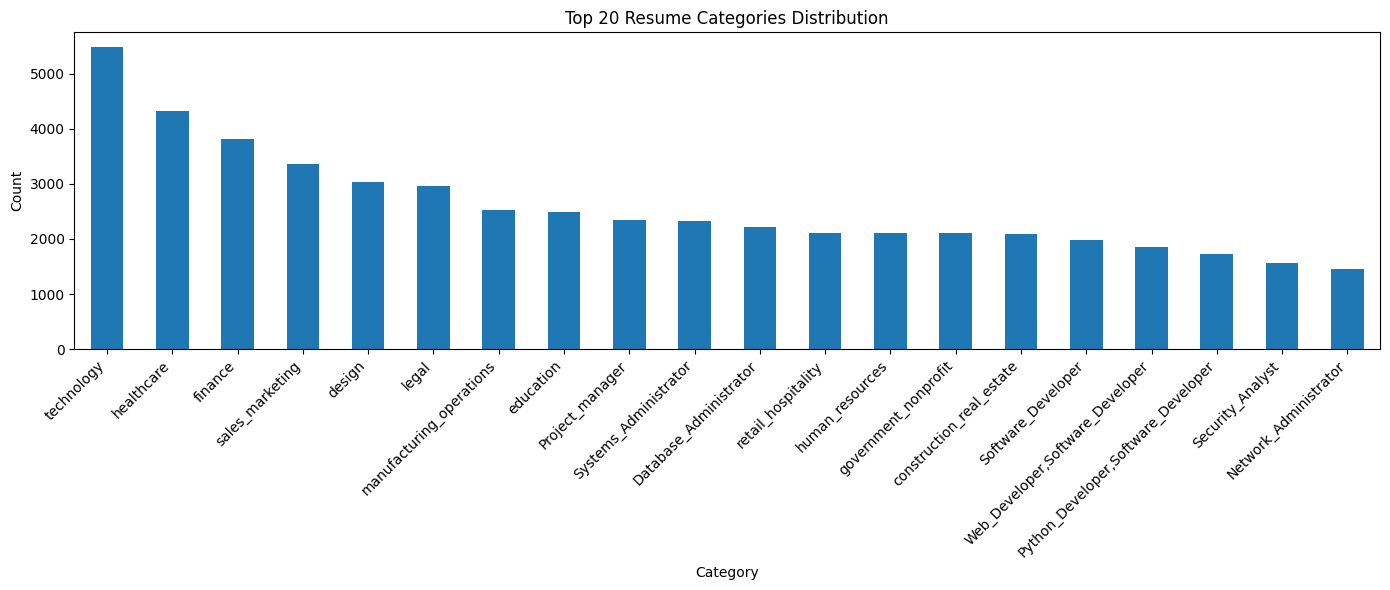

In [ ]:
plt.figure(figsize=(14, 6))
df['Category'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Resume Categories Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Develop on Sample data

In [ ]:
# df = full_df.sample(n=10000, random_state=42)

## 5. Data Preprocessing

### 5.1 Text Cleaning

In [ ]:
def clean_resume_text(text):
  if not isinstance(text, str):
      return ""

  text = re.sub(r'http\S+|www\.\S+', '', text)

  text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

  text = re.sub(r'[^a-zA-Z\s]', '', text)

  text = re.sub(r'\s+', ' ', text).strip()

  return text.lower()

In [ ]:
print("Cleaning resume text...")
df['Resume'] = df['Resume'].parallel_apply(clean_resume_text)
print("Text cleaning completed")

display(df.head())

Cleaning resume text...


Text cleaning completed


,Category,Resume
0,Data Science,skills programming languages python pandas num...
1,Data Science,education details may to may be uitrgpv data s...
2,Data Science,areas of interest deep learning control system...
3,Data Science,skills r python sap hana tableau sap hana sql ...
4,Data Science,education details mca ymcaust faridabad haryan...


### 5.2 Initialize spaCy for NLP Processing

In [ ]:
nlp = spacy.load('en_core_web_sm')
print("spaCy model loaded successfully")

spaCy model loaded successfully


### 5.3 Tokenization, Lemmatization and POS with spaCy

In [ ]:
print("Processing text with spaCy (lemmatization & POS tagging)...")

texts = df['Resume'].tolist()
processed_texts = []

docs = nlp.pipe(texts, disable=["parser", "ner"], batch_size=50, n_process=-1)

for doc in tqdm(docs, total=len(texts), desc="Processing Resumes"):
    processed_texts.append(' '.join([
        f"{token.lemma_}_{token.pos_}" for token in doc
        if not token.is_stop and not token.is_punct and not token.is_space
    ]))

df['Resume_POS_text'] = processed_texts

print("\nspaCy processing with POS tags completed.")
display(df[['Resume', 'Resume_POS_text']].head())

Processing text with spaCy (lemmatization & POS tagging)...


Processing Resumes:   0%|          | 0/93943 [00:00<?, ?it/s]


spaCy processing with POS tags completed.


,Resume,Resume_POS_text
0,skills programming languages python pandas num...,skill_VERB program_VERB language_NOUN python_N...
1,education details may to may be uitrgpv data s...,education_NOUN detail_NOUN uitrgpv_PROPN data_...
2,areas of interest deep learning control system...,area_NOUN interest_NOUN deep_ADJ learn_VERB co...
3,skills r python sap hana tableau sap hana sql ...,skill_NOUN r_X python_PROPN sap_PROPN hana_PRO...
4,education details mca ymcaust faridabad haryan...,education_NOUN detail_NOUN mca_PROPN ymcaust_P...


## 6. Category Normalization

### 6.1 Define Category Normalization Functions

In [ ]:
def normalize_job_titles(df):
    role_variations = {
        'software_developer': ['software engineer', 'software dev', 'programmer',
                              'application developer', 'software engineering', 'technology'],
        'java_developer': ['java engineer', 'java programmer'],
        'python_developer': ['python engineer', 'python programmer'],
        'web_developer': ['web dev', 'website developer'],
        'frontend_developer': ['front end', 'front-end', 'ui developer'],
        'backend_developer': ['back end', 'back-end'],
        'fullstack_developer': ['full stack', 'full-stack'],
        'data_scientist': ['data science'],
        'data_analyst': ['data analysis'],
        'data_engineer': ['data engineering'],
        'network_administrator': ['network admin', 'network engineer'],
        'system_administrator': ['sysadmin', 'systems administrator'],
        'devops_engineer': ['devops', 'dev ops'],
        'project_manager': ['program manager', 'technical project manager'],
        'qa_engineer': ['quality assurance', 'test engineer', 'tester'],
        'mobile_developer': ['android developer', 'ios developer'],
        'database_administrator': ['dba', 'database engineer'],
        'security_engineer': ['cybersecurity', 'information security'],
    }

    title_map = {}
    for base, variations in role_variations.items():
        title_map[base.replace('_', ' ')] = base
        for var in variations:
            title_map[var] = base

    def normalize_category(cat):
        if not isinstance(cat, str):
            return cat

        cat = cat.lower().strip()
        cat = re.sub(r'[_\-/]', ' ', cat)

        if cat in title_map:
            return title_map[cat]

        for key, value in title_map.items():
            if key in cat:
                return value

        return re.sub(r'\s+', '_', re.sub(r'[^a-z0-9\s]', '', cat).strip())

    df['Category'] = df['Category'].parallel_apply(normalize_category)
    return df

def consolidate_multi_labels(df):
    priority_roles = [
        'java_developer', 'python_developer', 'web_developer',
        'frontend_developer', 'backend_developer', 'fullstack_developer',
        'mobile_developer', 'data_scientist', 'data_engineer', 'data_analyst',
        'devops_engineer', 'qa_engineer', 'security_engineer',
        'database_administrator', 'network_administrator', 'system_administrator',
        'project_manager', 'software_developer'
    ]

    def pick_best_label(cat):
        if not isinstance(cat, str) or ',' not in cat:
            return cat

        labels = [l.strip() for l in cat.split(',')]

        for priority_role in priority_roles:
            if priority_role in labels:
                return priority_role

        return labels[0]

    df['Category'] = df['Category'].parallel_apply(pick_best_label)
    return df

def clean_categories(df, min_samples=10):
    print("\nCategory Distribution (Before Cleaning):")
    print(df['Category'].value_counts().head(20))

    counts = df['Category'].value_counts()
    valid = counts[counts >= min_samples].index
    df_filtered = df[df['Category'].isin(valid)]

    removed = len(df) - len(df_filtered)
    print(f"\nRemoved {removed} samples with rare categories")
    print(f"Final shape: {df_filtered.shape}")
    print(f"Unique categories: {df_filtered['Category'].nunique()}")

    return df_filtered

print("Category normalization functions defined")

Category normalization functions defined


### 6.2 Apply Category Normalization

In [ ]:
print("Normalizing categories...")
df = normalize_job_titles(df)
df = consolidate_multi_labels(df)
df = clean_categories(df, min_samples=10)

print("\nCategory normalization completed")
display(df['Category'].value_counts().head(20))

Normalizing categories...



Category Distribution (Before Cleaning):
Category
software_developer          21412
healthcare                   4554
finance                      4374
network_administrator        3947
system_administrator         3471
sales_marketing              3365
design                       3031
legal                        2966
education                    2887
project_manager              2735
manufacturing_operations     2521
database_administrator       2512
human_resources              2411
retail_hospitality           2115
government_nonprofit         2101
construction_real_estate     2088
security_analyst             1561
media_entertainment          1340
data_scientist               1148
product_manager               761
Name: count, dtype: int64

Removed 7 samples with rare categories
Final shape: (93936, 3)
Unique categories: 96

Category normalization completed


,count
Category,
software_developer,21412
healthcare,4554
finance,4374
network_administrator,3947
system_administrator,3471
sales_marketing,3365
design,3031
legal,2966
education,2887


## 7. Saving Preprocessed Data

In [ ]:
df.to_csv('preprocessed_resumes.csv', index=False)

print("Preprocessed data saved to preprocessed_resumes.csv")

Preprocessed data saved to preprocessed_resumes.csv


## 8. Feature Extraction (Word Embeddings)

### 8.1 Text to Sequences

In [ ]:
vocab_size = 10000
max_length = 500
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Resume_POS_text'])
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(df['Resume_POS_text'])

X_padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')
y = df['Category']

print(f"Shape of padded sequences (X): {X_padded.shape}")
print(f"Shape of labels (y): {y.shape}")

Shape of padded sequences (X): (93936, 500)
Shape of labels (y): (93936,)


## 9. Model Preparation

### 9.1 Import Modeling Libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

print("Modeling libraries imported successfully!")

Modeling libraries imported successfully!


### 9.2 Encode Labels and Split Data

In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

y_categorical = to_categorical(y_encoded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_padded, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_categorical
)

print(f"Data split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Number of categories: {y_categorical.shape[1]}")

Data split into training and testing sets.
X_train shape: (75148, 500)
X_test shape: (18788, 500)
Number of categories: 96


## 10. Build the LSTM Model

In [ ]:
num_classes = y_train.shape[1]

model = Sequential()

model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length))

model.add(LSTM(128, dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.build(input_shape=(None, max_length))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 96)             │        12,384 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423,968 (5.43 MB)

 Trainable params: 1,423,968 (5.43 MB)

 Non-trainable params: 0 (0.00 B)

## 11. Train the Model

### 11.1 Fit the Model to the Training Data

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

print("Starting model training...")

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[early_stopping]
)

print("Model training completed!")

Starting model training...
Epoch 1/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.2239 - loss: 3.3041 - val_accuracy: 0.3351 - val_loss: 2.3393
Epoch 2/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 32s 28ms/step - accuracy: 0.3872 - loss: 2.1469 - val_accuracy: 0.5683 - val_loss: 1.4129
Epoch 3/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.6392 - loss: 1.2585 - val_accuracy: 0.7216 - val_loss: 1.0032
Epoch 4/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.7507 - loss: 0.8755 - val_accuracy: 0.7991 - val_loss: 0.7175
Epoch 5/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.8116 - loss: 0.6729 - val_accuracy: 0.8387 - val_loss: 0.5812
Epoch 6/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.8538 - loss: 0.5182 - val_accuracy: 0.8641 - val_loss: 0.4889
Epoch 7/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 33s 28ms/step - accuracy: 0.8870 - loss: 0.4023 - val_accuracy: 0.8802 - val_loss: 0.4298
Epoch 8/20
1175/1175 ━━━━━━━━━━━━━━━━━━━━ 35s 30m

## 12. Evaluate the Model

### 12.1 Calculate Final Loss and Accuracy

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

Test Accuracy: 89.62%
Test Loss: 0.3687


### 12.2 Confusion Matrix

588/588 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
Classification Report:
                                  precision    recall  f1-score   support

                      accountant       0.85      0.93      0.89       115
                        advocate       0.91      0.80      0.85       107
                     agriculture       0.69      0.75      0.72        71
                     ai_engineer       1.00      1.00      1.00         3
                   ai_researcher       1.00      1.00      1.00        45
                         apparel       0.83      0.64      0.72       102
                 ar_vr_developer       1.00      1.00      1.00        47
                    architecture       0.52      0.48      0.50        61
                            arts       0.75      0.60      0.67        93
              automation_testing       1.00      0.67      0.80         3
                      automobile       0.50      0.53      0.52        75
                        aviation       0.81    

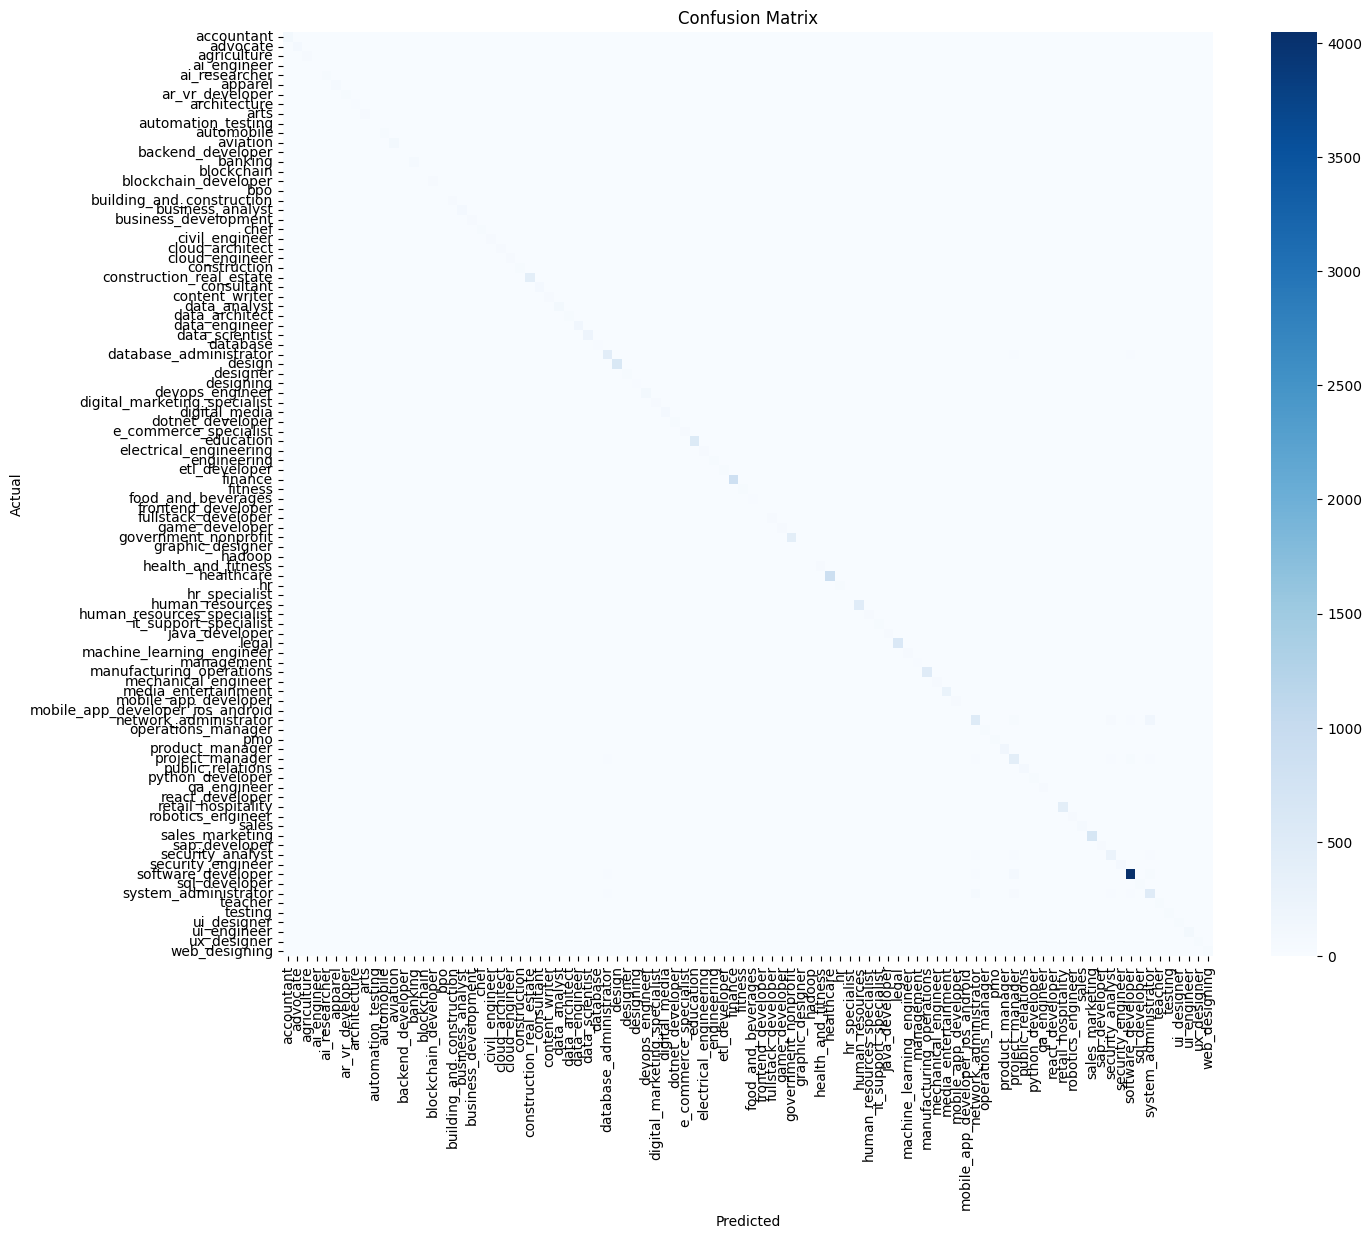

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### 12.3 Visualize Training History

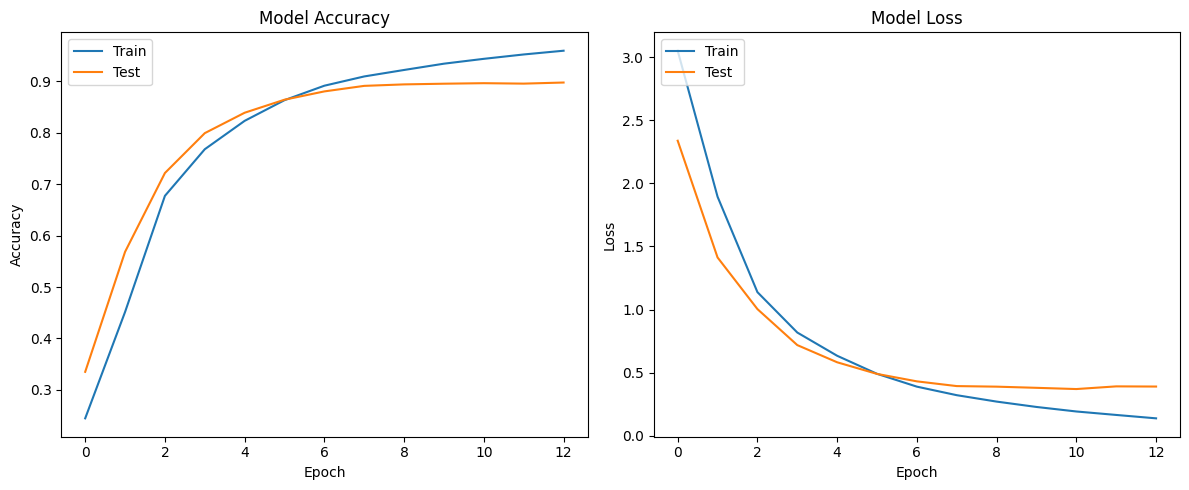

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
sample_resume = """ Dr. Evelyn Reed
Senior Data Scientist
(555) 123-4567 | e.reed.data@email.com | linkedin.com/in/evelynreed | San Francisco, CA

================================================================================
SUMMARY
================================================================================

Data-driven and results-oriented Senior Data Scientist with 7+ years of experience in leveraging advanced statistical analysis and machine learning to solve complex business problems. Proven expertise in developing and deploying end-to-end predictive models, leading data-driven strategy, and mentoring junior team members. Seeking to leverage deep technical skills in Python, SQL, and cloud platforms to drive innovation and business growth.

================================================================================
TECHNICAL SKILLS
================================================================================

* **Programming & Databases:** Python (Expert), R (Proficient), SQL (Expert), PostgreSQL, MySQL, NoSQL (MongoDB)
* **Python Libraries:** Pandas, NumPy, Scikit-learn, TensorFlow, Keras, PyTorch, Matplotlib, Seaborn, Plotly
* **ML & Statistics:** Predictive Modeling, Classification, Regression, Clustering, Natural Language Processing (NLP), Time Series Analysis, Statistical Inference, A/B Testing, Recommender Systems
* **Data Visualization:** Tableau, Power BI, Looker, Matplotlib
* **Big Data & Cloud:** Apache Spark (PySpark), AWS (S3, SageMaker, Redshift, EC2), Google Cloud Platform (GCP), Docker
* **Tools:** Git, Jupyter Notebooks, Airflow, Agile/Scrum Methodologies

================================================================================
PROFESSIONAL EXPERIENCE
================================================================================

Senior Data Scientist | FinTech Innovations Inc. | San Francisco, CA
(2020 - Present)

* Led the end-to-end development of a real-time credit risk model using XGBoost and Scikit-learn, resulting in a 25% reduction in loan defaults and saving an estimated $1.5M annually.
* Developed a sophisticated customer churn prediction model using logistic regression and random forests, which identified at-risk customers with 85% accuracy, enabling targeted retention campaigns.
* Engineered an NLP model using BERT to analyze over 500,000 customer support tickets, automatically categorizing issues and identifying key drivers of customer dissatisfaction.
* Designed and maintained complex ETL pipelines using SQL and Python (Airflow) to process over 10TB of transactional data for analysis.
* Mentored a team of 3 junior data scientists, providing guidance on model development, coding best practices, and statistical theory.
* Collaborated with product managers and engineers to define project requirements, set realistic timelines, and present findings to C-level executives.

Data Scientist | E-Commerce Solutions | Boston, MA
(2017 - 2020)

* Built and deployed a collaborative filtering recommendation engine for an e-commerce platform with 10M+ users, increasing average order value by 15% and user engagement by 20%.
* Conducted in-depth A/B tests on website layout and pricing strategies, providing statistical validation for changes that led to a 5% increase in conversion rates.
* Created interactive dashboards in Tableau and Power BI to monitor key performance indicators (KPIs) for the marketing department, providing actionable insights into campaign performance.
* Performed customer segmentation analysis using K-Means clustering to identify high-value customer groups, informing targeted marketing strategies.

================================================================================
PROJECTS
================================================================================

**Stock Price Prediction using NLP on Financial News**
* Developed a model to predict stock market movements (up/down/neutral) by analyzing the sentiment of financial news headlines.
* Utilized NLTK for text preprocessing and a TF-IDF vectorizer with a Naive Bayes classifier.
* Achieved 72% accuracy in predicting daily market trends for a basket of tech stocks.

**Kaggle Competition: Customer Churn Prediction**
* Participated in a telecom customer churn prediction competition.
* Performed extensive feature engineering and hyperparameter tuning on a large dataset.
* Ranked in the top 10% of participants by achieving a high AUC score using a Gradient Boosting Machine (GBM).

================================================================================
EDUCATION
================================================================================

**Ph.D. in Computer Science (Specialization in Machine Learning)**
Stanford University | Stanford, CA
(2012 - 2017)
* Dissertation: "Scalable Algorithms for Real-Time Anomaly Detection in High-Volume Data Streams"

**B.S. in Statistics (Summa Cum Laude)**
University of California, Berkeley | Berkeley, CA
(2008 - 2012)
"""

In [ ]:
# Preprocess the sample resume
cleaned_resume = clean_resume_text(sample_resume)

doc = nlp(cleaned_resume)
processed_resume = ' '.join([
    f"{token.lemma_}_{token.pos_}" for token in doc
    if not token.is_stop and not token.is_punct and not token.is_space
])

sequence = tokenizer.texts_to_sequences([processed_resume])

padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

# Make the prediction
prediction = model.predict(padded_sequence)

# Get the predicted class index
predicted_class_index = np.argmax(prediction, axis=1)[0]

# Decode the predicted class index back to the original category name
predicted_category = encoder.classes_[predicted_class_index]

print(f"The predicted category for the sample resume is: {predicted_category}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
The predicted category for the sample resume is: data_scientist


# Load Preprocessed Dataset

In [ ]:
# df = pd.read_csv('preprocessed_resumes.csv')

# Load The Tokenizer & Model

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import pickle

# # Load the tokenizer
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)
# print("Tokenizer loaded successfully.")

# # Load the trained model
# model = load_model('resume_classifier_model.keras')
# print("Model loaded successfully.")

In [ ]:
import pickle

# 1. Save the trained model
model.save('resume_classifier_model.keras')
print("Model saved to resume_classifier_model.keras")

# 2. Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer saved to tokenizer.pickle")

# Save the LabelEncoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("LabelEncoder saved to label_encoder.pickle")

Model saved to resume_classifier_model.keras
Tokenizer saved to tokenizer.pickle
LabelEncoder saved to label_encoder.pickle
